In [338]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras import optimizers
import time


In [339]:
def creat_dataset(dataset, look_back=1):  # look_back表示用当前项的前look_back项预测当前1项
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i: (i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)


In [340]:
dataframe = pd.read_excel('updatedDataset.xlsx',sheet_name = 'BTC-USD')
dataframe

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072
...,...,...,...,...,...,...,...
1457,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
1458,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299
1459,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018
1460,2021-12-31,47169.371094,48472.527344,45819.953125,46306.445313,46306.445313,36974172400


In [341]:
dataframe = dataframe.iloc[:,[0,4]]

In [342]:
dataframe

,Date,Close
0,2018-01-01,13657.200195
1,2018-01-02,14982.099609
2,2018-01-03,15201.000000
3,2018-01-04,15599.200195
4,2018-01-05,17429.500000
...,...,...
1457,2021-12-28,47588.855469
1458,2021-12-29,46444.710938
1459,2021-12-30,47178.125000
1460,2021-12-31,46306.445313


In [343]:
dataset = dataframe.values
dataset

array([[Timestamp('2018-01-01 00:00:00'), 13657.200195],
       [Timestamp('2018-01-02 00:00:00'), 14982.099609],
       [Timestamp('2018-01-03 00:00:00'), 15201.0],
       ...,
       [Timestamp('2021-12-30 00:00:00'), 47178.125],
       [Timestamp('2021-12-31 00:00:00'), 46306.445313],
       [Timestamp('2022-01-01 00:00:00'), 47686.8125]], dtype=object)

In [344]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:,1].reshape(-1, 1))
# 时间序列不需要显式的时间标签，只需要一个数值组成的序列即可

In [345]:
dataset

array([[0.16198395],
       [0.18257929],
       [0.18598206],
       ...,
       [0.68306106],
       [0.66951095],
       [0.69096852]])

In [346]:
train_size = int(len(dataset)*0.85)
test_size = len(dataset)-train_size
train, test = dataset[0: train_size], dataset[train_size: len(dataset)]

In [347]:
look_back = 5
trainX, trainY = creat_dataset(train, look_back)
testX, testY = creat_dataset(test, look_back)

In [348]:
trainX.shape  # 第一个是样本总数，第二个是每一个样本中的时间序列的长度，第三个是每一个时间序列中的每一个元素的编码长度

(1237, 5, 1)

In [349]:
model = Sequential()

model.add(LSTM(100, input_shape=(trainX.shape[1],trainX.shape[2])))
#model.add(Dropout(0.2))

# model.add(LSTM(100, return_sequences=False))
# #model.add(Dropout(0.2))

# model.add(LSTM(200, return_sequences=True))
# #model.add(Dropout(0.2))

# model.add(LSTM(300, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Dense(1))

model.add(Activation('relu'))
start = time.time()
model.compile(loss='mean_squared_error', optimizer='Adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
_________________________________________________________________
activation_12 (Activation)   (None, 1)                 0         
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
_________________________________________________________________


In [350]:
history = model.fit(trainX, trainY, batch_size=64, nb_epoch=50, 
                    validation_split=0.1, verbose=2)
print('compilatiom time:', time.time()-start)

Train on 1113 samples, validate on 124 samples
Epoch 1/50
 - 7s - loss: 0.0036 - val_loss: 0.0073
Epoch 2/50
 - 0s - loss: 2.7038e-04 - val_loss: 0.0100
Epoch 3/50
 - 0s - loss: 2.4225e-04 - val_loss: 0.0022
Epoch 4/50
 - 0s - loss: 1.6246e-04 - val_loss: 0.0026
Epoch 5/50
 - 0s - loss: 1.7505e-04 - val_loss: 0.0026
Epoch 6/50
 - 0s - loss: 1.5445e-04 - val_loss: 0.0040
Epoch 7/50
 - 0s - loss: 1.7053e-04 - val_loss: 0.0022
Epoch 8/50
 - 0s - loss: 1.4548e-04 - val_loss: 0.0023
Epoch 9/50
 - 0s - loss: 1.3179e-04 - val_loss: 0.0028
Epoch 10/50
 - 0s - loss: 1.9806e-04 - val_loss: 0.0026
Epoch 11/50
 - 0s - loss: 1.7856e-04 - val_loss: 0.0023
Epoch 12/50
 - 0s - loss: 1.4311e-04 - val_loss: 0.0027
Epoch 13/50
 - 0s - loss: 1.5714e-04 - val_loss: 0.0027
Epoch 14/50
 - 0s - loss: 1.5991e-04 - val_loss: 0.0033
Epoch 15/50
 - 0s - loss: 1.3183e-04 - val_loss: 0.0019
Epoch 16/50
 - 0s - loss: 1.0909e-04 - val_loss: 0.0022
Epoch 17/50
 - 0s - loss: 1.5317e-04 - val_loss: 0.0019
Epoch 18/50
 -

In [351]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [352]:
trainPredict

array([[0.21277064],
       [0.22266564],
       [0.21746454],
       ...,
       [0.5197724 ],
       [0.5414824 ],
       [0.55074674]], dtype=float32)

In [353]:
trainY

array([[0.22213934],
       [0.20582659],
       [0.18550172],
       ...,
       [0.55136301],
       [0.54664114],
       [0.56050677]])

In [354]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [355]:
trainPredict.shape

(1237, 1)

In [356]:
trainY.shape

(1237, 1)

In [357]:
testPredict.shape

(215, 1)

In [358]:
testY.shape

(215, 1)

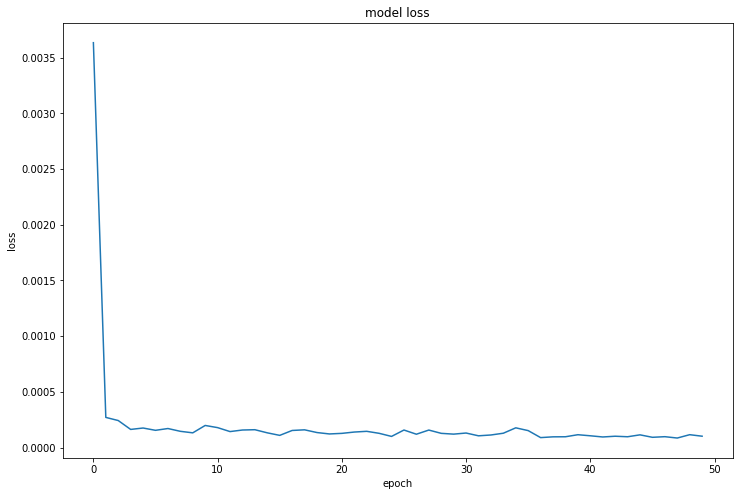

In [359]:
fig1 = plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [360]:
trainPredictPlot = np.zeros(shape=dataset.shape)
trainPredictPlot[:,:] = np.nan
trainPredictPlot = np.reshape(trainPredictPlot, (dataset.shape[0], 1))
# 使用之前的look_back+1个的数据预测当前的1个数据，所以从第look_back+1个才开始预测
trainPredictPlot[look_back: len(trainPredict)+look_back, :] = trainPredict

In [361]:
testPredictPlot = np.zeros(shape=dataset.shape)
testPredictPlot[:,:] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1))
testPredictPlot[(len(trainPredict)+look_back)+look_back: len(dataset), :] = testPredict

In [362]:
dataset

array([[0.16198395],
       [0.18257929],
       [0.18598206],
       ...,
       [0.68306106],
       [0.66951095],
       [0.69096852]])

In [363]:
dataset = scaler.inverse_transform(dataset)
dataset

array([[13657.200195],
       [14982.099609],
       [15201.      ],
       ...,
       [47178.125   ],
       [46306.445313],
       [47686.8125  ]])

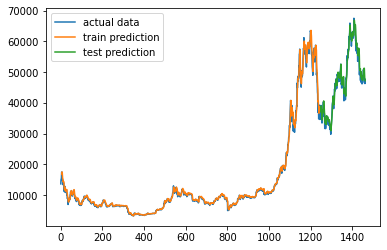

In [364]:
plt.plot(dataset,label = 'actual data')
plt.plot(trainPredictPlot,label = 'train prediction')
plt.plot(testPredictPlot,label = 'test prediction')
plt.legend()

In [365]:
# sum_t = 0
# testY = testY.reshape(-1,)
# testPredict = testPredict.reshape(-1,)
# print(testY.shape)
# print(testPredict.shape)
# for i in range(len(testY)):
#     testY[i] = testY[i] / (max(testY) - min(testY))
#     testPredict[i] = testPredict[i] / (max(testPredict) - min(testPredict))
# for i in range(len(testY)):
#     sum_t += (testPredict[i] - testY[i])**2
# rmse = (sum_t / len(testPredict))**0.5
# rmse

In [366]:
import numpy as np
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score#R 2
#调用

# mean_absolute_error(testY,testPredict)
np.sqrt(mean_squared_error(testY,testPredict))  # RMSE就是对MSE开方即可



1880.7490901853307

In [367]:
r2_score(testY,testPredict)

0.9630563000425713

In [368]:
#  MAPE和SMAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

#  调用
mape(testY, testPredict)


3.2154105518745535